# A/B-тест

# Содержание

- Шаг 1. Загрузим данные и подготовим их к анализу.
- Шаг 2. Подготовим данные.
- Шаг 3. Приоритизация гипотез.
- Шаг 4. Анализ A/B-теста.
- 4.1 График кумулятивной выручки по дням и группам A/B-тестирования.
- 4.2 График среднего чека по дням.
- 4.3 График относительного различия для среднего чека.
- 4.4 График кумулятивной конверсии по группам.
- 4.5 График относительного изменения кумулятивной конверсии группы B к группе A.
- 4.6 Точечный график количества заказов по пользователям.
- 4.7 Расчёт 95-й и 99-й перцентили количества заказов на пользователя.
- 4.8 Точечный график стоимостей заказов.
- 4.9 Расчёт 95-й и 99-й перцентили стоимости заказов.
- 4.10 Расчёт статистической значимости различий в конверсии между группами по «сырым» данным.
- 4.11 Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.
- 4.12 Расчёт статистической значимости различий в конверсии между группами по «очищенным» данным.
- 4.13 Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.
- Шаг 5. Общий вывод.

# Шаг 1. Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime as dt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
pd.set_option('display.max_colwidth', -1)
import datetime
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings('ignore')

C:\Users\A261~1\AppData\Local\Temp/ipykernel_14208/4020238352.py:11: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [3]:
df_list = [hypothesis,orders,visitors]
for df in df_list:
    print('Первые 5 строк')
    print('-'*50)
    display(df.head())
    print('-'*50)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('-'*50)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*50)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*50)
    print('Наличие пропусков')
    print('-'*50)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*50)
    display(df.describe())

Первые 5 строк
--------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


--------------------------------------------------
Размер датафрейма: (строк:столбцов) (9, 5)
--------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
--------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------
Наличие пропусков
--------------------------------------------------
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
Стат данные
--------------------------------------------------


,Reach,Impact,Confidence,Efforts
count,9.00,9.00,9.00,9.00
mean,4.78,4.78,5.56,4.89
std,3.15,3.19,3.05,2.80
min,1.00,1.00,1.00,1.00
25%,3.00,3.00,3.00,3.00
50%,3.00,3.00,7.00,5.00
75%,8.00,7.00,8.00,6.00
max,10.00,10.00,9.00,10.00


Первые 5 строк
--------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


--------------------------------------------------
Размер датафрейма: (строк:столбцов) (1197, 5)
--------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
--------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------
Наличие пропусков
--------------------------------------------------
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Стат данные
---------------------------------------------

,transactionId,visitorId,revenue
count,"1,197.00","1,197.00","1,197.00"
mean,"2,155,621,385.53","2,165,960,143.10","8,348.01"
std,"1,229,084,904.76","1,236,014,192.15","39,191.13"
min,"1,062,393.00","5,114,589.00",50.00
25%,"1,166,775,572.00","1,111,826,046.00","1,220.00"
50%,"2,145,193,898.00","2,217,984,702.00","2,978.00"
75%,"3,237,740,112.00","3,177,606,451.00","8,290.00"
max,"4,293,855,558.00","4,283,872,382.00","1,294,500.00"


Первые 5 строк
--------------------------------------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


--------------------------------------------------
Размер датафрейма: (строк:столбцов) (62, 3)
--------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
--------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------
Наличие пропусков
--------------------------------------------------
date        0
group       0
visitors    0
dtype: int64
Стат данные
--------------------------------------------------


,visitors
count,62.00
mean,607.29
std,114.40
min,361.00
25%,534.00
50%,624.50
75%,710.50
max,770.00


# Шаг 2. Подготовка данных

Приведём к нижнему регистру названия столбцов:

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

Все временные столбцы переведем в тип datetime64:

In [5]:
orders['date']=pd.to_datetime(orders['date'])
visitors['date']=pd.to_datetime(visitors['date'])

проверим нет ли пользователей, которые оказались в обеих группах одновременно:

In [6]:
group_sizes = orders.groupby(['visitorId', 'group']).size().reset_index()
group_sizes.columns = ['visitorId', 'group', 'count']
group_sizes = group_sizes.query('count > 1').sort_values(by='visitorId')
print(group_sizes.head(5))

     visitorId group  count
45   199603092  A     4    
58   237748145  A     4    
63   249864742  B     3    
94   366673373  A     2    
104  393266494  B     2    


In [7]:
potentially_broken_users_list = list(zip(group_sizes['visitorId'], group_sizes['group']))
potentially_broken_users_dict = defaultdict(list)
for user, group in potentially_broken_users_list:
    potentially_broken_users_dict[user].append(group)

inappropriate_users = [user for user in potentially_broken_users_dict if len(potentially_broken_users_dict[user]) > 1]
inappropriate_orders = orders.query('visitorId in @inappropriate_users')
inappropriate_orders_grouped = (inappropriate_orders
                        .groupby(['visitorId', 'group', 'date'])
                        .agg({'transactionId': 'nunique', 'revenue': 'sum'})
                   )
inappropriate_orders_grouped

transactionId  revenue
visitorId  group date                              
1230306981 A     2019-08-09  3              18440  
           B     2019-08-09  2              12840  
2038680547 A     2019-08-04  2              4070   
                 2019-08-17  1              3470   
                 2019-08-22  1              760    
                 2019-08-25  1              270    
           B     2019-08-04  1              2800   
                 2019-08-15  1              1680   
                 2019-08-29  1              2420   
2378935119 A     2019-08-10  1              58220  
                 2019-08-15  1              1650   
                 2019-08-17  1              310    
                 2019-08-22  1              3390   
           B     2019-08-09  1              30649  
                 2019-08-10  1              2640   
                 2019-08-25  1              21220  
                 2019-08-28  2              24860  
2458001652 A     2019-08-04  1              340    
                 2019-08-06  1              1620   
                 2019-08-07  1              17379  
                 2019-08-11  1              8280   
                 2019-08-22  1              5190   
           B     2019-08-05  1              2420   
                 2019-08-06  2              14030  
                 2019-08-08  1              5227   
                 2019-08-09  1              5227   
                 2019-08-25  1              2385   
4256040402 A     2019-08-01  1              5800   
                 2019-08-12  1              50     
                 2019-08-17  1              1550   
                 2019-08-20  1              17650  
                 2019-08-23  1              16950  
                 2019-08-27  1              1630   
                 2019-08-31  1              5170   
           B     2019-08-08  1              58220  
                 2019-08-16  1              56650  
                 2019-08-18  1              10970  
                 2019-08-31  1              1850

In [8]:
orders_groups_count = (orders.groupby(['visitorId']).agg({'group': 'nunique'}).reset_index())
orders_both_AB = orders_groups_count[orders_groups_count['group'] > 1]
orders_both_AB.count()[0]

58

Так как в рамках этого A/B теста не пользователей, а сесии разделяли на группы, то проблемы в том, что пользователь попал в обе группы, нет. Просто так вышло, что он совершил несколько сессий, которые определились в разные группы.

# Шаг 3. Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Для приоритизации применим фреймворки ICE и RICE

In [9]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_ICE = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)
hypothesis_ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [10]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_RICE = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_RICE

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [11]:
priority_of_hypothesis = hypothesis_ICE.merge(hypothesis_RICE, on='hypothesis')
priority_of_hypothesis

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


При применении ICE наиболее перспективные гипотезы 8, 0, 7 и 6, а RICE показывает, что на первом месте уже гипотеза 7, потом 2,0 и 6. Это произошло потому что параметр охвата у гипотезы 7 намного выше. То есть эти изменения затронут большее количество пользователей.

# Шаг 4. Анализ A/B-теста.

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [13]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [14]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [15]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [16]:
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01  A     24      20      148579   719     
1 2019-08-01  B     21      20      101217   713     
2 2019-08-02  A     44      38      242401   1338    
3 2019-08-02  B     45      43      266748   1294    
4 2019-08-03  A     68      62      354874   1845    


## 4.1 Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

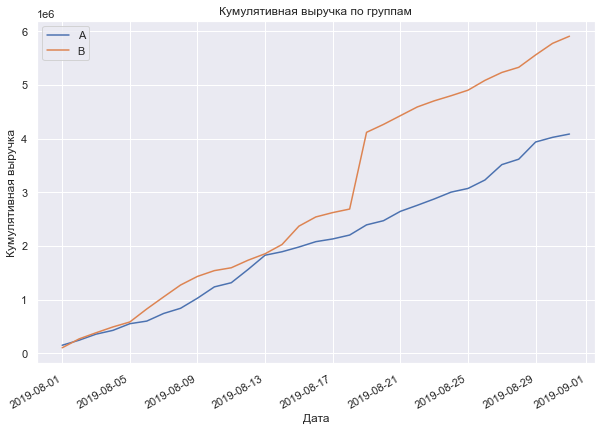

In [19]:
# Строим график выручки группы А
fig = plt.figure(figsize=[10,7])

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
fig.autofmt_xdate()
plt.legend()
plt.show()

In [20]:
trace_A = go.Scatter(
    x = cumulativeRevenueA['date'],
    y = cumulativeRevenueA['revenue'],
    mode = 'lines+markers',
    name = 'A'
)
trace_B = go.Scatter(
    x = cumulativeRevenueB['date'],
    y = cumulativeRevenueB['revenue'],
    mode = 'lines+markers',
    name = 'B'
)

layout = go.Layout(
    title='Кумулятивная выручка по группам',
    xaxis_title='Дата',
    yaxis_title='Кумулятивная выручка'
)   
  

fig = go.Figure(data = [trace_A, trace_B], layout = layout)
iplot(fig)

Выручка увеличивается в течение всего теста, но график выручки группы B в одной точке резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

## 4.2 Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

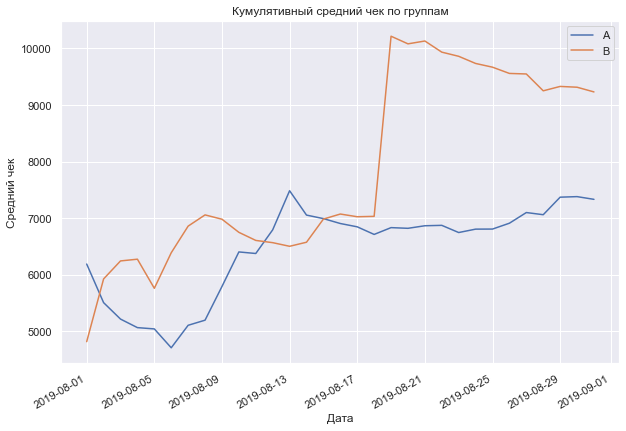

In [21]:
fig = plt.figure(figsize=[10,7])
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
fig.autofmt_xdate()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.show()

In [22]:
trace_A = go.Scatter(
    x = cumulativeRevenueA['date'],
    y = cumulativeRevenueA['revenue'],
    mode = 'lines+markers',
    name = 'A'
)
trace_B = go.Scatter(
    x = cumulativeRevenueB['date'],
    y = cumulativeRevenueB['revenue'],
    mode = 'lines+markers',
    name = 'B'
)

layout = go.Layout(
    title='Кумулятивный средний чек по группам',
    xaxis_title='Дата',
    yaxis_title='Средний чек'
)   

fig = go.Figure(data = [trace_A, trace_B], layout = layout)
iplot(fig)

Средний чек становится более равномерным к концу теста: немного растет для группы A и и продолжает падать для группы B. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике).

## 4.3 Построим график относительного различия для среднего чека:

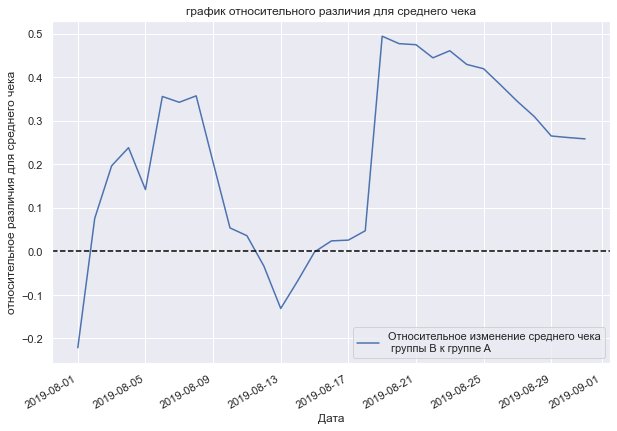

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig = plt.figure(figsize=[10,7])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, label="Относительное изменение среднего чека\n группы B к группе A")
fig.autofmt_xdate()
plt.legend(loc='lower right')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('график относительного различия для среднего чека')
plt.xlabel('Дата')
plt.ylabel('относительное различия для среднего чека')
plt.show()

График различия между сегментами резко «скачет». Сначала средний чек группы B стабильно растет, потом резко падает и резко взлетает. Возможно это влияние крупных заказов и выбросов.

## 4.4 Построим график кумулятивной конверсии по группам:

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [25]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [26]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

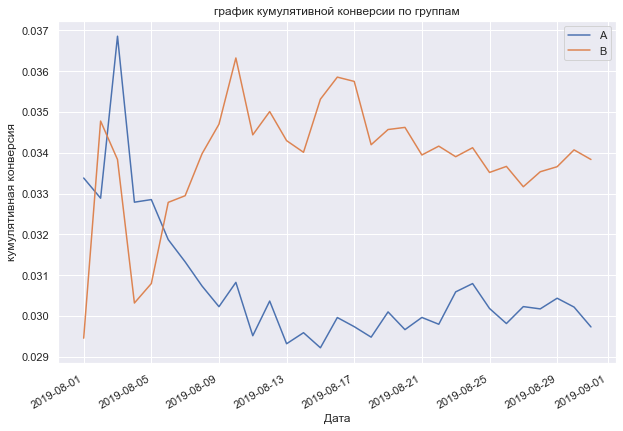

In [29]:
# строим графики
fig = plt.figure(figsize=[10,7])
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
fig.autofmt_xdate()
plt.legend()

# задаем масштаб осей
plt.title('график кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('кумулятивная конверсия')
plt.show()

In [32]:
layout = go.Layout(title='График кумулятивной конверсии по группам',
                  xaxis_title = 'Дата',
                  yaxis_title = 'Конверсия')
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x = cumulativeDataA['date'],
                         y = cumulativeDataA['conversion'], mode = 'lines+markers', name='A'))
fig.add_trace(go.Scatter(x = cumulativeDataB['date'],
                         y = cumulativeDataB['conversion'], mode = 'lines+markers', name='B'))
fig.show()

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

## 4.5 Построим график относительного изменения кумулятивной конверсии группы B к группе A:

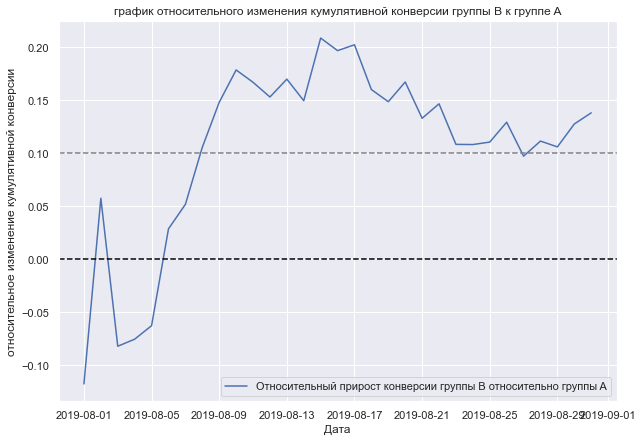

In [34]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=[10,7])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend(loc="lower right")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('график относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('относительное изменение кумулятивной конверсии')
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Конверсия группы B стабильно выше. Стоит проанализировать аномалии, возможно результаты изменятся.

## 4.6 Построим точечный график количества заказов по пользователям:

In [35]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['userId', 'orders']

In [36]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

          userId  orders
1023  4256040402  11    
591   2458001652  11    
569   2378935119  9     
487   2038680547  8     
44    199603092   5     
744   3062433592  5     
55    237748145   5     
917   3803269165  5     
299   1230306981  5     
897   3717692402  5     


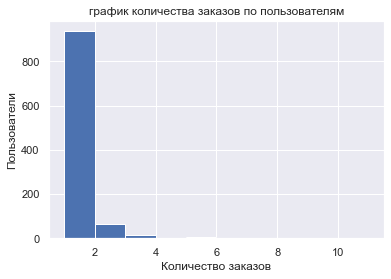

In [37]:
plt.hist(ordersByUsers['orders'])
plt.title('график количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Пользователи')
plt.show()

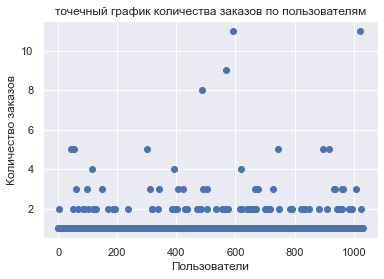

In [38]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна. Также присутствует несколько покупателей с большим количеством заказов

## 4.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей:

In [39]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа.

Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

## 4.8 Построим точечный график стоимостей заказов:

In [40]:
orders['revenue'].describe()

count   1,197.00    
mean    8,348.01    
std     39,191.13   
min     50.00       
25%     1,220.00    
50%     2,978.00    
75%     8,290.00    
max     1,294,500.00
Name: revenue, dtype: float64

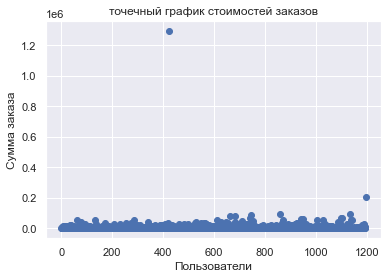

In [41]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Сумма заказа')
plt.show()

Практически все стоимости заказов находятся в пределах 100000, но есть выбросы со стоимостями более миллиона. Именно этот заказ отразился на всех графиках.

## 4.9 Посчитаем 95-й и 99-й перцентили стоимости заказов.Выберем границу для определения аномальных заказов:

In [42]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Менее 5% заказов стоят дороже 30000, можно взять эту цифру за границу для определения аномальных заказов

## 4.10 Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным:

- Для расчета р-value, я решил использовать напараметрический тест Уилкоксона-Манна-Уитни, так как у нас имеются выбросы, а сам тест работает с рангами, не учитывая сами значения. 


- Так же сформирую нулевую и альтернативную гипотезы. 


- **Нулевая гипотеза: статистически значимых различий в конверсии между группами нет.**


- **Альтернативная гипотеза:статистически значимые различия в конверсии между группами есть.** 


- Порогом статистической значимости установим alpha=.05

In [43]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [44]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

In [45]:
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [46]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [47]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

In [48]:
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [49]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [50]:
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [51]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [52]:
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [53]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [54]:
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [55]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [56]:
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [57]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Посчитаем статистическую значимость различия в конверсии между группами:

In [58]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

In [59]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [60]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [61]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]  

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [62]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [63]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.017
0.138


-  p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. 
- Относительный выигрыш группы B равен 13.8%.

## 4.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным:

-  Сформирую нулевую и альтернативную гипотезы. 


- **Нулевая гипотеза: статистически значимых различий в в среднем чеке между группами нет.**
    
    
- **Альтернативная гипотеза:статистически значимые различия в в среднем чеке между группами есть.**
    
    
- Порог статистической значимости - alpha=0.05

In [64]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


- P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. - Впрочем, средний чек группы B  выше среднего чека группы A на 25,9%.

## 4.12 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным:

Вспомним, что найденные ранее 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

- **Нулевая гипотеза: статистически значимых различий в конверсии между группами нет.**
    
    
- **Альтернативная гипотеза:статистически значимые различия в конверсии между группами есть.** 
    
    
- Порог статистической значимости - alpha=0.05

In [65]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)

In [66]:
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [67]:
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
461     154576532
928     204675465
684     358944393
dtype: int64
(86,)


86 аномальных пользователя

Узнаем, как их действия повлияли на результаты теста:

In [68]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [69]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [70]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.023
0.149



Результаты по конверсии практически не изменились. p-value остался значительно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем.

По очищенным данным есть статистически значимые различия в конверсии групп A и B. Относительный прирост конверсии группы B около 14,9%

## 4.13 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:

- **Нулевая гипотеза: статистически значимых различий в в среднем чеке между группами нет.**
    
    
- **Альтернативная гипотеза:статистически значимые различия в в среднем чеке между группами есть.** 
    
    
- Порог статистической значимости - alpha=0.05

In [71]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.866
-0.002


P-value практически не изменился, а разница между сегментами сильно изменилась. Очищенные данные показывают, что средний чек группы B немного уступает группе A, в то время как на сырых данных чек группы B был на 26% больше.

По очищенным данным статистически значимых различий среднего чека между группами нет.

Хотя статистической зачимости и нет, стоит отметить, что разница из положительной стала отрицательной - это дополнительно показывает вклад аномалии.

# Шаг 5. Общий вывод

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Как по сырым, так и по очищенным данным нет статистически значимого различия по среднему чеку между группами.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту и практически зафиксировались.
- График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.
    
На основании результатов, можно остановить тест и зафиксировать победу группы B. Так как есть статистически значимое различие по конверсии между группами, относительный прирост конверсии группы B около 15%.  